In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gzip
import pickle
from time import time

import numpy as np
import matplotlib.pyplot as plt

import svetoch as svet
import svetoch.cuda
import svetoch.tensor as ten
import svetoch.nn as nn
import svetoch.nn.functional as F

In [3]:
train, valid, test = pickle.load(gzip.open('data/mnist.pkl.gz'), encoding='latin1')

In [4]:
train[0].shape, train[1].shape, valid[0].shape, test[0].shape

((50000, 784), (50000,), (10000, 784), (10000, 784))

In [5]:
def normalize(x, mean, std):
    """Subtract mean and divide by std to make x mean 0 and std 1."""
    return (x - mean) / std

def denorm(x):
    """Restore original mean and std. Complement to normalize()."""
    return x * train_std + train_mean

train_mean, train_std = train[0].mean(), train[0].std()
train[0].min(), train[0].max(), train_mean, train_std

(0.0, 0.99609375, 0.13044983, 0.3072898)

In [6]:
train = (normalize(train[0], train_mean, train_std), train[1])
valid = (normalize(valid[0], train_mean, train_std), valid[1])
test = (normalize(test[0], train_mean, train_std), test[1])
print(train[0].mean(), train[0].std(),
      valid[0].mean(), valid[0].std(),
      test[0].mean(), test[0].std())

-3.1638146e-07 0.99999934 -0.005850922 0.99243325 0.005034822 1.0064359


In [7]:
print(train[0].min(), train[0].max(),
      denorm(train[0]).min(), denorm(train[0]).max())

-0.42451727 2.8170278 0.0 0.99609375


In [8]:
n_in = test[0].shape[1] # length of input vector
n_out = test[1].max() + 1 # number of output classes
n_in, n_out

(784, 10)

In [9]:
class Resize(nn.Module):
    def forward(self, x):
        return x.reshape((-1, 1, 28, 28))

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape((len(x), -1))

def get_model():
    return nn.Sequential(
        Resize() # 784 -> 1x28x28
        # weight 8x1x5x5 = 8x25
        ,nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU() # -> 8x14x14
        # weight 16x8x3x3 = 16x72
        ,nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU() # -> 16x7x7
        # weight 32x16x3x3 = 32x144
        ,nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU() # -> 32x4x4
        ,Flatten() # 32x4x4 -> 512
        # weight 512x10
        ,nn.Linear(32 * 4 * 4, n_out) # -> 10
    )

In [10]:
dev = 'cpu'
if svet.cuda.is_available():
    dev = 'cuda'
dev

'cpu'

In [11]:
class TimeCallback:
    def before_fit(self):
        self.t0 = time()

    def after_fit(self):
        print('total time %.2fs' % (time() - self.t0,))

class StatsCallback:
    def __init__(self):
        self.train_losses, self.valid_losses, self.accuracies = [], [], []

    def before_epoch(self):
        self.train_loss, self.valid_loss, self.accuracy = 0, 0, 0
        self.train_cnt, self.valid_cnt = 0, 0

    def after_loss(self):
        cnt = len(self.learn.xb)
        if self.learn.training:
            # loss is averaged over batch size, restore orig value by
            # multiplying by batch size
            self.train_loss += self.learn.loss.detach() * cnt
            self.train_cnt += cnt
        else:
            self.accuracy += (self.learn.preds.argmax(axis=1) == self.learn.yb).sum()
            self.valid_loss += self.learn.loss * cnt
            self.valid_cnt += cnt

    def after_epoch(self):
        self.train_losses.append(self.train_loss.item() / self.train_cnt)
        self.valid_losses.append(self.valid_loss.item() / self.valid_cnt)
        self.accuracies.append(self.accuracy.item() / self.valid_cnt)
        print('%3d. train loss %.4f | valid loss %.4f | accuracy %.4f' %
              (self.learn.epoch, self.train_losses[-1], self.valid_losses[-1],
               self.accuracies[-1]))

In [12]:
batch_size = 100
lr = .1

In [13]:
def get_data_loader(x, y, shuffle=False, first_n=None):
    if first_n:
        x, y = x[:first_n], y[:first_n]
    x, y = map(lambda x: ten.tensor(x, device=dev), [x, y])
    ds = svet.data.TensorDataset(x, y)
    return svet.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_dl = get_data_loader(*train, shuffle=True)
valid_dl = get_data_loader(*valid)
model = get_model().to(dtype=ten.float32, device=dev)
optim = svet.optim.SGD(model.parameters(), lr, set_to_none=True)
stats = StatsCallback()
learner = svet.learn.Learner(train_dl, model, optim, F.cross_entropy,
    valid_data_loader=valid_dl, callbacks=[TimeCallback(), stats])

In [14]:
module2layer = {}
fwd_stats, bwd_stats = {}, {}

def forward_hook(module, _, out):
    out = out.detach()
    stats = fwd_stats[module2layer[module]]
    stats['mean'].append(out.mean())
    stats['std'].append(out.std())
    stats['hist'].append(out.histc(80, -20, 20))

def backward_hook(module, in_grad, _):
    stats = bwd_stats[module2layer[module]]
    stats['weight_grad'].append(in_grad[1].abs().sum())
    stats['bias_grad'].append(in_grad[2].abs().sum())

for layer, module in enumerate(model):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        module.add_forward_hook(forward_hook)
        fwd_stats[layer] = {'mean': [], 'std': [], 'hist': []}
        module.add_backward_hook(backward_hook)
        bwd_stats[layer] = {'bias_grad': [], 'weight_grad': []}
        module2layer[module] = layer

In [15]:
learner.fit(5)

  0. train loss 0.3135 | valid loss 0.1593 | accuracy 0.9531
  1. train loss 0.1234 | valid loss 0.1066 | accuracy 0.9698
  2. train loss 0.0894 | valid loss 0.0914 | accuracy 0.9742
  3. train loss 0.0727 | valid loss 0.1013 | accuracy 0.9721
  4. train loss 0.0622 | valid loss 0.0794 | accuracy 0.9769
total time 526.91s


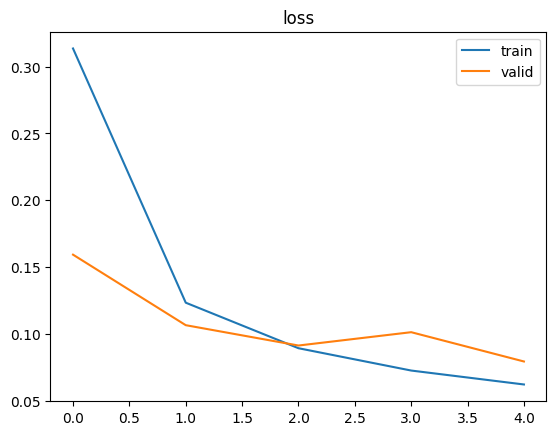

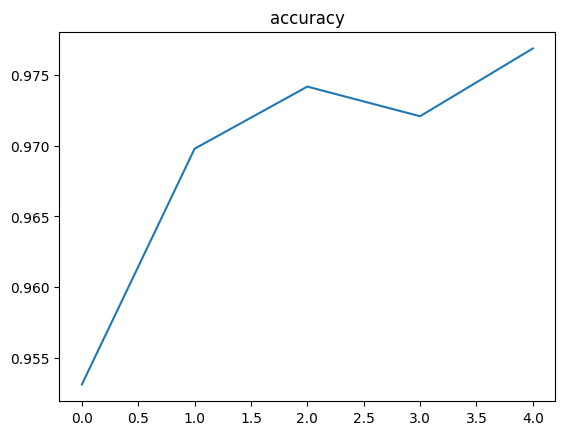

In [16]:
plt.title('loss')
plt.plot(stats.train_losses, label='train')
plt.plot(stats.valid_losses, label='valid')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(stats.accuracies)

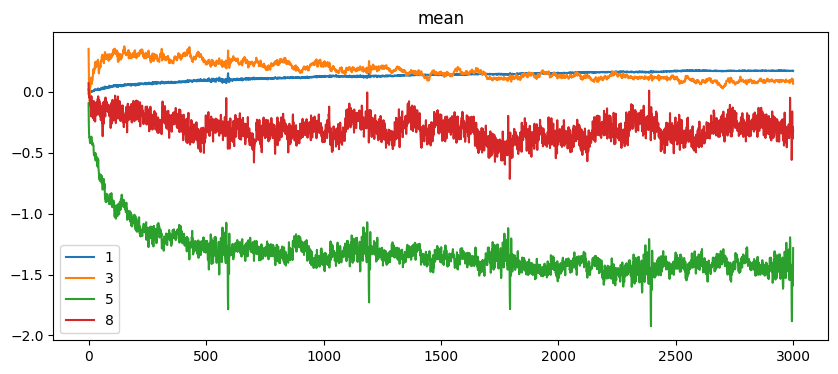

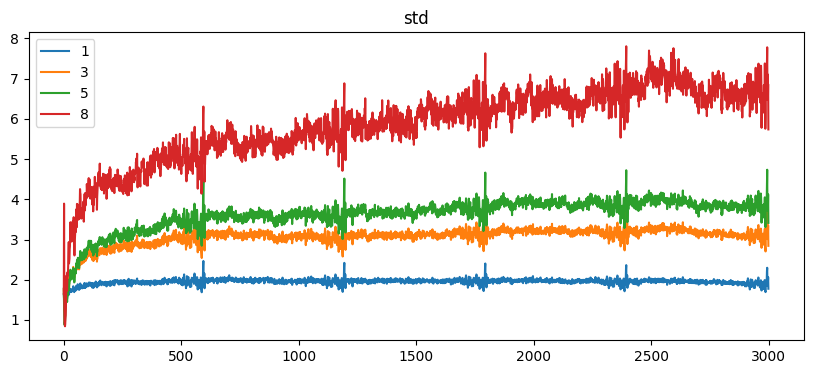

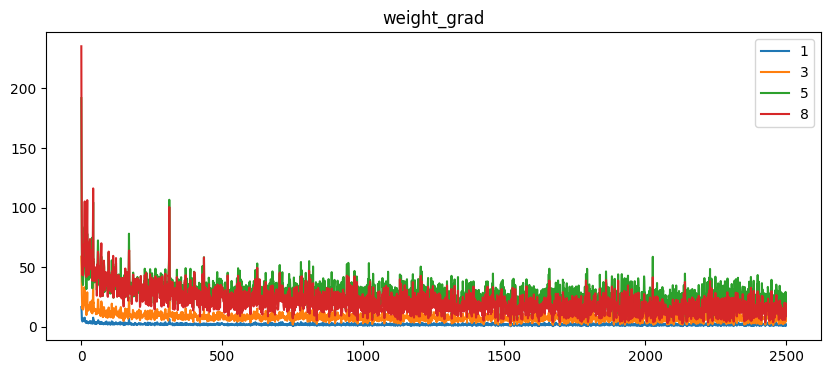

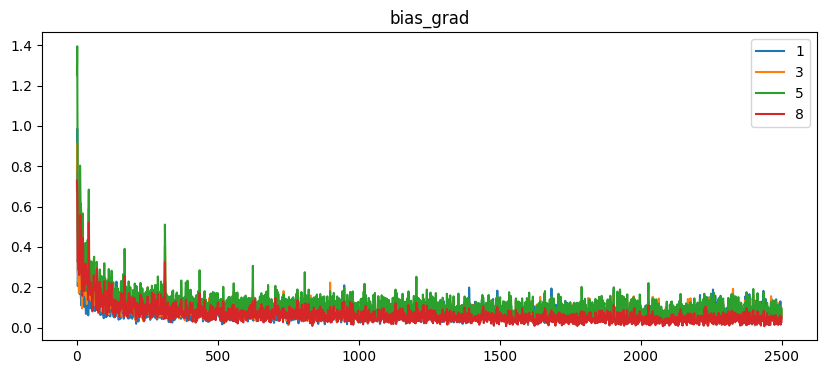

In [17]:
def plot_layer_stats(stats, name):
    plt.figure(figsize=(10, 4))
    plt.title(name)
    for layer, vals in stats.items():
        plt.plot(ten.tensor(vals[name]).cpu(), label=layer)
    plt.legend()
    plt.show()

plot_layer_stats(fwd_stats, 'mean')
plot_layer_stats(fwd_stats, 'std')
plot_layer_stats(bwd_stats, 'weight_grad')
plot_layer_stats(bwd_stats, 'bias_grad')

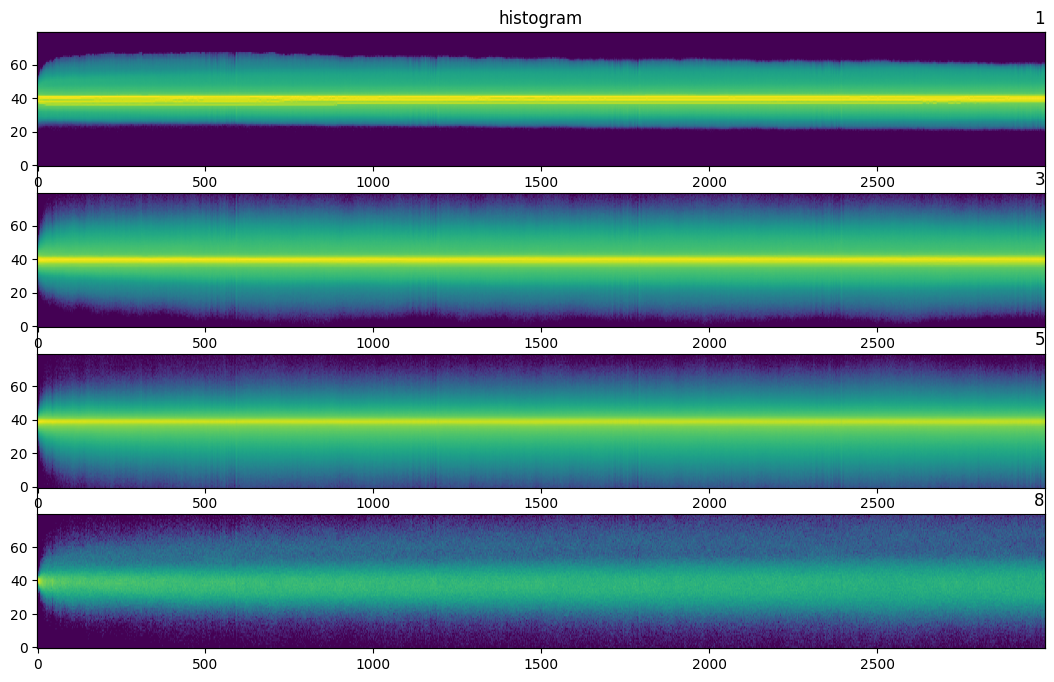

In [18]:
plt.figure(figsize=(13, 8))
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('histogram')
for i, (layer, vals) in enumerate(fwd_stats.items()):
    hist = ten.tensor(vals['hist']).T.float().log1p().cpu()
    ax = plt.subplot(len(fwd_stats), 1, i + 1)
    ax.set_title(layer, loc='right')
    ax.imshow(hist, origin='lower', aspect='auto')